# Fruit classification

https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class



In [2]:
import tensorflow  as  tf
from  tensorflow  import  keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn

import numpy as  np
import matplotlib.pyplot  as  plt
import os
import cv2
import random
import cv2 as cv
import pandas  as  pd
import tqdm as tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#print the number of GPU

print ( "Num GPUs Available: " ,  len ( tf.config.experimental.list_physical_devices ( 'GPU' )))

#import  the confusion matrix
from sklearn.metrics import confusion_matrix


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)


callbacks = [
    early_stopping,
    lr_scheduler,
]


2023-01-04 13:52:46.011481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 13:52:46.486159: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-04 13:52:46.643924: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-04 13:52:47.427407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Num GPUs Available:  1


2023-01-04 13:52:49.380421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 13:52:49.381299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 13:52:49.381435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 13:52:49.381661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4117 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-01-04 13:52:49.383898: I tensorflow/stream_executor/cuda/cuda_

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.
['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


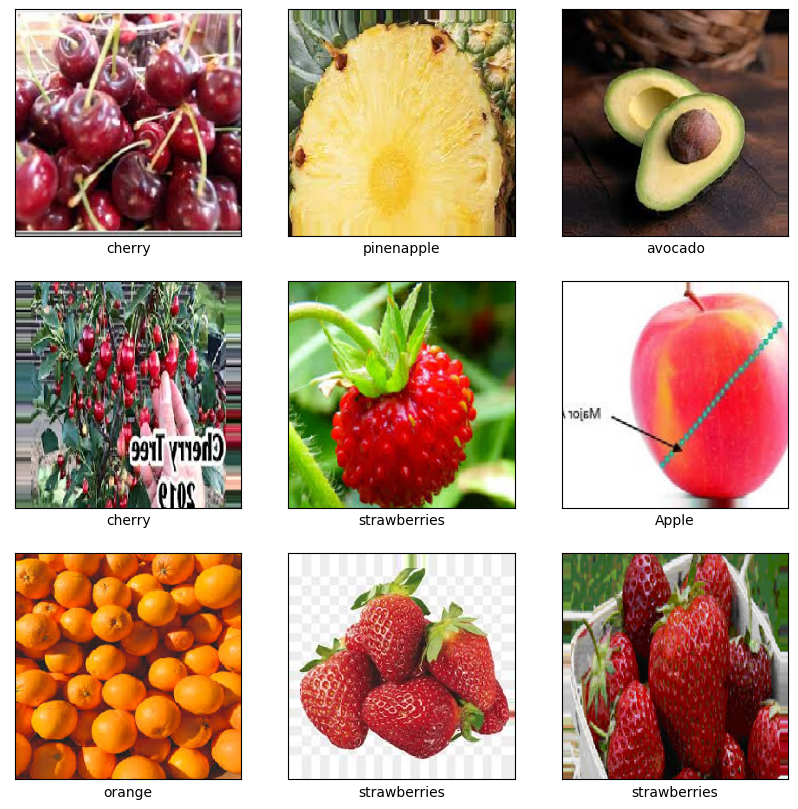

(32, 224, 224, 3)


In [4]:
pathTrain = "./food/train"
pathTest = "./food/test"

generator = ImageDataGenerator(rescale=1./255, validation_split=0.2, zoom_range=0.2, horizontal_flip=True)

train_generator = generator.flow_from_directory(
    pathTrain,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = generator.flow_from_directory(
    pathTrain,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = generator.flow_from_directory(
    pathTest,
    target_size=(224, 224),
    class_mode='categorical'
)

class_indices = list(train_generator.class_indices.keys())
print(class_indices)

#show some images with their labels
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_generator[0][0][i])
    plt.xlabel(class_indices[train_generator[0][1][i].argmax()])
plt.show()

#print the shape of the images
print(train_generator[0][0].shape)



{'apple': 0, 'banana': 1, 'avocado': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'strawberries': 8, 'watermelon': 9}
1


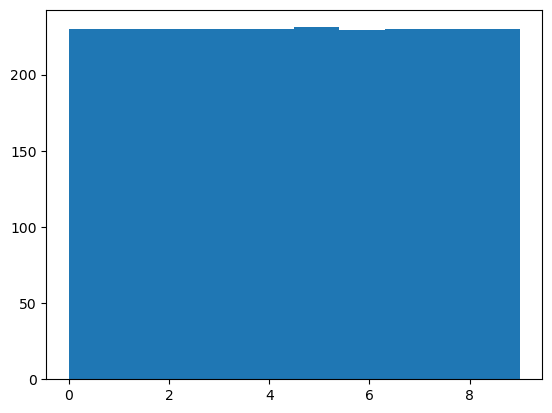

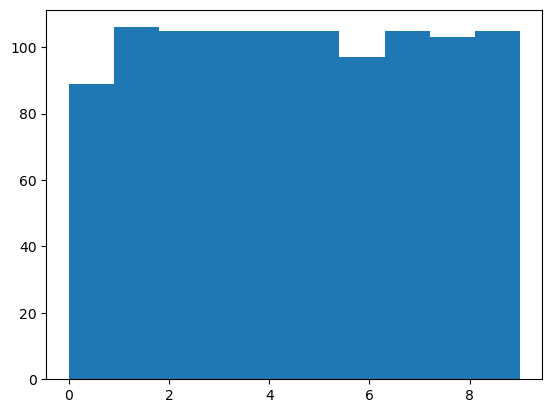

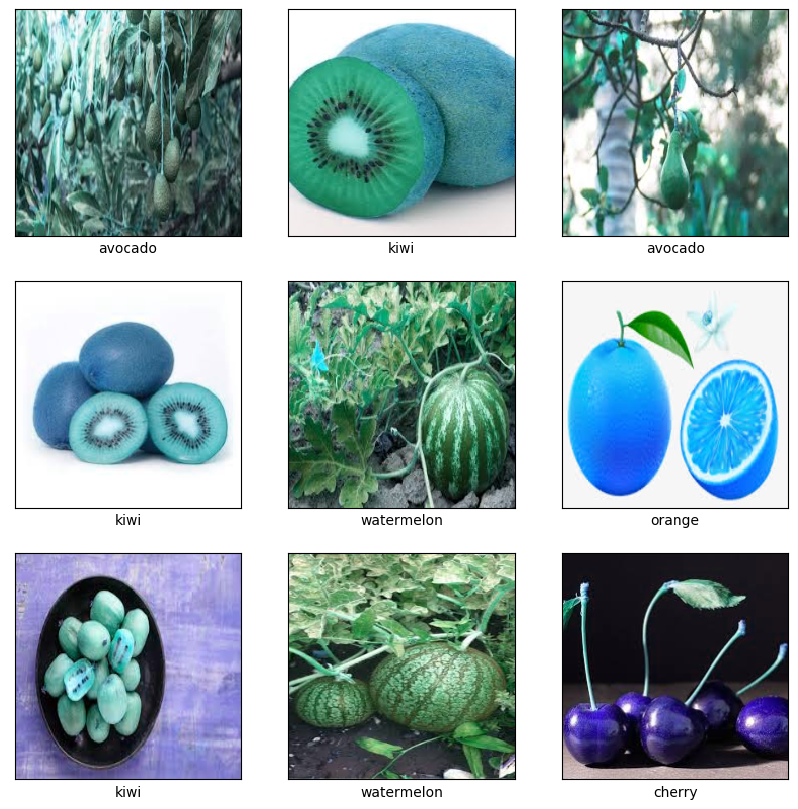

(1840, 224, 224, 3)
(1840,)
(460, 224, 224, 3)
(460,)
(1025, 224, 224, 3)
(1025,)


In [3]:
pathTrain = "./food/train"
pathTest = "./food/test"


#for each folder in the dataset folder, split the data into training and test set

train_x = []
train_y = []
test_x = []
test_y = []

cont = 0
#for each folder in the dataset folder, get the names of the folders and use a dict to store an incremental number for each folder
class_names = os.listdir(pathTrain)
class_names.sort()
class_dict = {}
for i in range(len(class_names)):
    class_dict[class_names[i].lower()] = i

print(class_dict)



#load the images and resize them to 224x224
for i in os.listdir(pathTrain):
    for j in os.listdir(pathTrain + "/" + i):
        path = pathTrain + "/" + i + "/" + j
        #read the color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            cont += 1
            continue

        #resize the image
        img = cv2.resize(img, (224, 224))
        #add the image to the training set
        train_x.append(img)
        #add the label to the training set
        train_y.append(class_dict[i.lower()])
        
for i in os.listdir(pathTest):
    for j in os.listdir(pathTest + "/" + i):
        path = pathTest + "/" + i + "/" + j
        #read the color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            cont += 1
            continue

        #resize the image
        img = cv2.resize(img, (224, 224))
        #add the image to the test set
        test_x.append(img)
        #add the label to the test set
        test_y.append(class_dict[i.lower()])



print(cont)

#plot the distribution of the labels in the training set showing each x
plt.hist(train_y, bins=10)
plt.show()

#plot the distribution of the labels in the test set showing each x
plt.hist(test_y, bins=10)
plt.show()

#two fold cross validation
#split the training set into two folds
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

#convert the lists to numpy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

#normalize the images
train_x = train_x / 255
val_x = val_x / 255
test_x = test_x / 255

#convert the labels to one hot encoding
val_y_one_hot = np.zeros((val_y.shape[0], 10))

for i in range(val_y.shape[0]):
    val_y_one_hot[i, val_y[i]] = 1

train_y_one_hot = np.zeros((train_y.shape[0], 10))

for i in range(train_y.shape[0]):
    train_y_one_hot[i, train_y[i]] = 1

test_y_one_hot = np.zeros((test_y.shape[0], 10))

for i in range(test_y.shape[0]):
    test_y_one_hot[i, test_y[i]] = 1



#show some images with their labels
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i])
    plt.xlabel(class_names[train_y[i]])
plt.show()

#print the shapes
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)



# Model 1

There are 4 convolution layers, each having a conv2d, maxPolling (to reduce the size of the image) and a dropout layer. The dropout layer is used to prevent overfitting. Only the first layer has batch normalization layer added to it. After the convolution phase, the image is flattened and then passed through 2 dense layers. The first dense layer has 512 neurons and the second dense layer has 10 neurons. The last layer has softmax activation function to give the probability of each class and has 10 neurons as there are 10 classes.


In [6]:
#create a new model 
model = keras.Sequential()

#use conv2d, maxpooling2d, dropout and batchnormalization
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0

2023-01-04 01:06:36.051670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:06:36.051870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:06:36.051957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:06:36.052088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:06:36.052176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])


history = model.fit(train_x, train_y_one_hot, epochs=100, batch_size=32, validation_data=(val_x, val_y_one_hot), callbacks=callbacks, verbose=1)

#save the model
model.save('modelFood.h5')

/home/theshadow/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100


2023-01-04 01:06:37.964237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-04 01:06:38.545844: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-04 01:06:38.547308: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-04 01:06:38.547322: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-01-04 01:06:38.547362: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

58/58 [==============================] - 8s 78ms/step - loss: 2.3183 - accuracy: 0.1815 - val_loss: 2.2668 - val_accuracy: 0.2239 - lr: 1.0000e-04
Epoch 2/100
58/58 [==============================] - 3s 59ms/step - loss: 1.6465 - accuracy: 0.4000 - val_loss: 2.1473 - val_accuracy: 0.3587 - lr: 1.0000e-04
Epoch 3/100
58/58 [==============================] - 3s 59ms/step - loss: 1.4114 - accuracy: 0.4837 - val_loss: 2.0379 - val_accuracy: 0.4565 - lr: 1.0000e-04
Epoch 4/100
58/58 [==============================] - 3s 59ms/step - loss: 1.2325 - accuracy: 0.5543 - val_loss: 1.9489 - val_accuracy: 0.4391 - lr: 1.0000e-04
Epoch 5/100
58/58 [==============================] - 3s 59ms/step - loss: 1.0855 - accuracy: 0.6076 - val_loss: 1.8380 - val_accuracy: 0.4761 - lr: 1.0000e-04
Epoch 6/100
58/58 [==============================] - 3s 59ms/step - loss: 0.9394 - accuracy: 0.6679 - val_loss: 1.6826 - val_accuracy: 0.5239 - lr: 1.0000e-04
Epoch 7/100
58/58 [==============================] - 3s 59

33/33 [==============================] - 1s 17ms/step - loss: 1.5009 - accuracy: 0.5863
[1.5009311437606812, 0.5863414406776428]
15/15 [==============================] - 0s 14ms/step - loss: 1.3690 - accuracy: 0.5978
[1.3689708709716797, 0.5978260636329651]


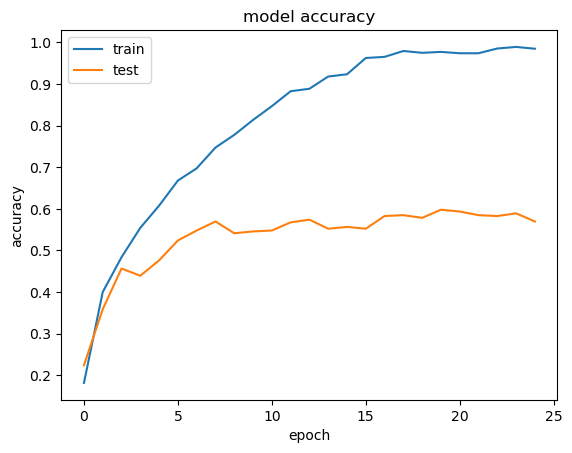

In [8]:
print(model.evaluate(test_x, test_y_one_hot))
print(model.evaluate(val_x, val_y_one_hot))

#plot the accuracy and loss
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()


# Model 2

The second model uses transfer learning. It uses the VGG16 model and adds a dense layer with 512 neurons and a dense layer with 10 neurons. The last layer has softmax activation function to give the probability of each class and has 10 neurons as there are 10 classes. 

In [4]:
#use the vgg16 model and use transfer learning
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in conv_base.layers:
    layer.trainable = False
    

model2 = keras.Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

history2 = model2.fit(train_x, train_y_one_hot, epochs=100, batch_size=32, validation_data=(val_x, val_y_one_hot), callbacks=callbacks, verbose=1)

#save the model
model2.save('modelFood2.h5')


/home/theshadow/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
58/58 [==============================] - 10s 171ms/step - loss: 1.4457 - accuracy: 0.5223 - val_loss: 0.9051 - val_accuracy: 0.7283 - lr: 1.0000e-04
Epoch 2/100
58/58 [==============================] - 7s 125ms/step - loss: 0.4950 - accuracy: 0.8864 - val_loss: 0.7818 - val_accuracy: 0.7326 - lr: 1.0000e-04
Epoch 3/100
58/58 [==============================] - 7s 125ms/step - loss: 0.2559 - accuracy: 0.9603 - val_loss: 0.6618 - val_accuracy: 0.7870 - lr: 1.0000e-04
Epoch 4/100
58/58 [==============================] - 7s 126ms/step - loss: 0.1355 - accuracy: 0.9924 - val_loss: 0.6225 - val_accuracy: 0.8022 - lr: 1.0000e-04
Epoch 5/100
58/58 [==============================] - 7s 126ms/step - loss: 0.0832 - accuracy: 0.9973 - val_loss: 0.5984 - val_accuracy: 0.8087 - lr: 1.0000e-04
Epoch 6/100
58/58 [==============================] - 7s 126ms/step - loss: 0.0592 - accuracy: 0.9989 - val_loss: 0.5986 - val_accuracy: 0.8109 - lr: 1.0000e-04
Epoch 7/100
58/58 [====================

In [ ]:
model2 = keras.models.load_model('modelFood2.h5')

print(model2.evaluate(test_x, test_y_one_hot))
print(model2.evaluate(val_x, val_y_one_hot))

#plot the accuracy and loss
plt.plot(history2.history['accuracy'])

plt.plot(history2.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [3]:
weight_decay = 1e-4
"""cnn_model  =  Sequential()
cnn_model.add(Conv2D(filters = 32, kernel_size = (2,2), input_shape = (50,50, 3), activation = 'relu',kernel_regularizer = l2(l2_reg)))
cnn_model.add(MaxPool2D(pool_size = (2,2)))

cnn_model.add(Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu',kernel_regularizer = l2(l2_reg)))
cnn_model.add(MaxPool2D(pool_size = (2,2)))

cnn_model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu',kernel_regularizer = l2(l2_reg)))
cnn_model.add(MaxPool2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.1))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(16, activation = 'relu'))
cnn_model.add(Dense(4, activation = 'softmax'))

#CNN Model Summary
cnn_model.summary()
"""

model3 = keras.Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.1))

model3.add(Flatten())

model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dense(10, activation = 'softmax'))



model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

2023-01-04 10:31:03.732563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:31:03.732932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:31:03.733081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:31:03.733296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:31:03.733442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [4]:
model3.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

history3 = model3.fit(train_x, train_y_one_hot, epochs=100, batch_size=32, validation_data=(val_x, val_y_one_hot), callbacks=callbacks, verbose=1)

#save the model
model3.save('modelFood3.h5')

/home/theshadow/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100


2023-01-04 10:31:35.859708: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-04 10:31:36.952658: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-04 10:31:36.953674: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-04 10:31:36.953685: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-01-04 10:31:36.953718: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

58/58 [==============================] - 8s 69ms/step - loss: 2.2402 - accuracy: 0.1707 - val_loss: 2.0933 - val_accuracy: 0.2043 - lr: 1.0000e-04
Epoch 2/100
58/58 [==============================] - 3s 50ms/step - loss: 1.9151 - accuracy: 0.2951 - val_loss: 1.7835 - val_accuracy: 0.3348 - lr: 1.0000e-04
Epoch 3/100
58/58 [==============================] - 3s 51ms/step - loss: 1.7057 - accuracy: 0.3560 - val_loss: 1.6825 - val_accuracy: 0.3674 - lr: 1.0000e-04
Epoch 4/100
58/58 [==============================] - 3s 51ms/step - loss: 1.6052 - accuracy: 0.3902 - val_loss: 1.6184 - val_accuracy: 0.3587 - lr: 1.0000e-04
Epoch 5/100
58/58 [==============================] - 3s 51ms/step - loss: 1.5294 - accuracy: 0.4190 - val_loss: 1.5566 - val_accuracy: 0.3978 - lr: 1.0000e-04
Epoch 6/100
58/58 [==============================] - 3s 51ms/step - loss: 1.4631 - accuracy: 0.4489 - val_loss: 1.5790 - val_accuracy: 0.3717 - lr: 1.0000e-04
Epoch 7/100
58/58 [==============================] - 3s 51

In [ ]:
print(model3.evaluate(test_x, test_y_one_hot))
print(model3.evaluate(val_x, val_y_one_hot))


#plot the accuracy and loss
plt.plot(history3.history['accuracy'])

plt.plot(history3.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()



# Model 4.1

In [ ]:
weight_decay = 1e-4

model4 = keras.Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.1))

#add layers with regularization
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.1))


model4.add(Flatten())

model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))
model4.add(Dense(10, activation = 'softmax'))



model4.summary()

In [ ]:
model4.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

history4 = model4.fit(train_x, train_y_one_hot, epochs=100, batch_size=32, validation_data=(val_x, val_y_one_hot), callbacks=callbacks, verbose=1)

#save the model
model4.save('modelFood4WithWeightDecay.h5')

# Model 4.2

In [7]:
weight_decay = 1e-2

model42 = keras.Sequential()
model42.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model42.add(MaxPooling2D((2, 2)))

model42.add(Conv2D(64, (3, 3), activation='relu'))
model42.add(MaxPooling2D((2, 2)))

model42.add(Conv2D(128, (3, 3), activation='relu'))
model42.add(MaxPooling2D((2, 2)))
model42.add(Dropout(0.1))

#add layers with regularization
model42.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model42.add(MaxPooling2D((2, 2)))
model42.add(Dropout(0.1))


model42.add(Flatten())

model42.add(Dense(64, activation = 'relu'))
model42.add(Dense(16, activation = 'relu'))
model42.add(Dense(10, activation = 'softmax'))



model42.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

In [8]:
model42.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])

history42 = model42.fit(train_x, train_y_one_hot, epochs=100, batch_size=32, validation_data=(val_x, val_y_one_hot), callbacks=callbacks, verbose=1)

#save the model
model42.save('modelFood42WithWeightDecay.h5')


/home/theshadow/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
58/58 [==============================] - 4s 56ms/step - loss: 3.5710 - accuracy: 0.1147 - val_loss: 3.5520 - val_accuracy: 0.1065 - lr: 1.0000e-05
Epoch 2/100
58/58 [==============================] - 3s 50ms/step - loss: 3.5261 - accuracy: 0.1234 - val_loss: 3.5031 - val_accuracy: 0.1348 - lr: 1.0000e-05
Epoch 3/100
58/58 [==============================] - 3s 50ms/step - loss: 3.4652 - accuracy: 0.1370 - val_loss: 3.4433 - val_accuracy: 0.1435 - lr: 1.0000e-05
Epoch 4/100
58/58 [==============================] - 3s 50ms/step - loss: 3.3913 - accuracy: 0.1598 - val_loss: 3.3655 - val_accuracy: 0.1826 - lr: 1.0000e-05
Epoch 5/100
58/58 [==============================] - 3s 50ms/step - loss: 3.2980 - accuracy: 0.2130 - val_loss: 3.2795 - val_accuracy: 0.1957 - lr: 1.0000e-05
Epoch 6/100
58/58 [==============================] - 3s 50ms/step - loss: 3.2143 - accuracy: 0.2190 - val_loss: 3.2101 - val_accuracy: 0.2370 - lr: 1.0000e-05
Epoch 7/100
58/58 [===========================

# Evaluation

Test Evaluation
33/33 [==============================] - 1s 15ms/step - loss: 1.5009 - accuracy: 0.5863
[1.5009311437606812, 0.5863414406776428]
Classification Report
33/33 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

       Apple       0.50      0.70      0.58        89
      Banana       0.47      0.48      0.47       106
     avocado       0.48      0.69      0.57       105
      cherry       0.55      0.72      0.63       105
        kiwi       0.77      0.54      0.64       105
       mango       0.35      0.28      0.31       105
      orange       0.89      0.69      0.78        97
  pinenapple       0.77      0.76      0.77       105
strawberries       0.65      0.51      0.58       103
  watermelon       0.61      0.51      0.56       105

    accuracy                           0.59      1025
   macro avg       0.60      0.59      0.59      1025
weighted avg       0.60      0.59      0.59      1025

33/33 [=============

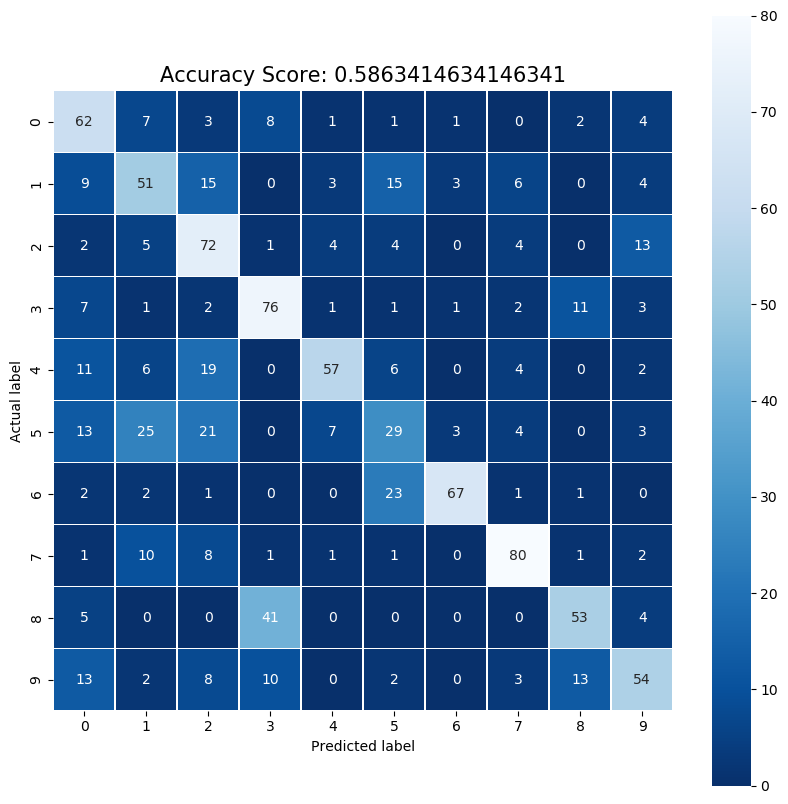

In [5]:
#load modelFood.h5 modelFood2.h5 modelFood3.h5
from sklearn.metrics import accuracy_score

modelFood1 = keras.models.load_model('modelFood.h5')

print("Test Evaluation")
print(modelFood1.evaluate(test_x, test_y_one_hot))

#compute the classification report

print("Classification Report")

print(classification_report(test_y_one_hot.argmax(axis=1), modelFood1.predict(test_x).argmax(axis=1), target_names=class_names))

#compute the confusion matrix with seaborn
cm = confusion_matrix(test_y_one_hot.argmax(axis=1), modelFood1.predict(test_x).argmax(axis=1))
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_y_one_hot.argmax(axis=1), modelFood1.predict(test_x).argmax(axis=1)))
plt.title(all_sample_title, size = 15)
plt.show()







2023-01-04 01:38:19.761395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:38:19.761589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:38:19.761672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:38:19.761800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 01:38:19.761885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Test Evaluation


2023-01-04 01:38:21.196221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-04 01:38:21.670960: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-04 01:38:21.671811: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-04 01:38:21.671823: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-01-04 01:38:21.671859: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

 2/33 [>.............................] - ETA: 3s - loss: 0.5708 - accuracy: 0.7969  

2023-01-04 01:38:26.338207: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


33/33 [==============================] - 9s 112ms/step - loss: 0.6826 - accuracy: 0.7834
[0.6825849413871765, 0.7834146618843079]
Classification Report
33/33 [==============================] - 3s 96ms/step
              precision    recall  f1-score   support

       Apple       0.80      0.84      0.82        89
      Banana       0.87      0.93      0.90       106
     avocado       0.78      0.86      0.81       105
      cherry       0.71      0.83      0.77       105
        kiwi       0.85      0.86      0.85       105
       mango       0.61      0.41      0.49       105
      orange       0.62      0.75      0.68        97
  pinenapple       0.94      0.90      0.92       105
strawberries       0.86      0.70      0.77       103
  watermelon       0.80      0.76      0.78       105

    accuracy                           0.78      1025
   macro avg       0.78      0.78      0.78      1025
weighted avg       0.78      0.78      0.78      1025

33/33 [============================

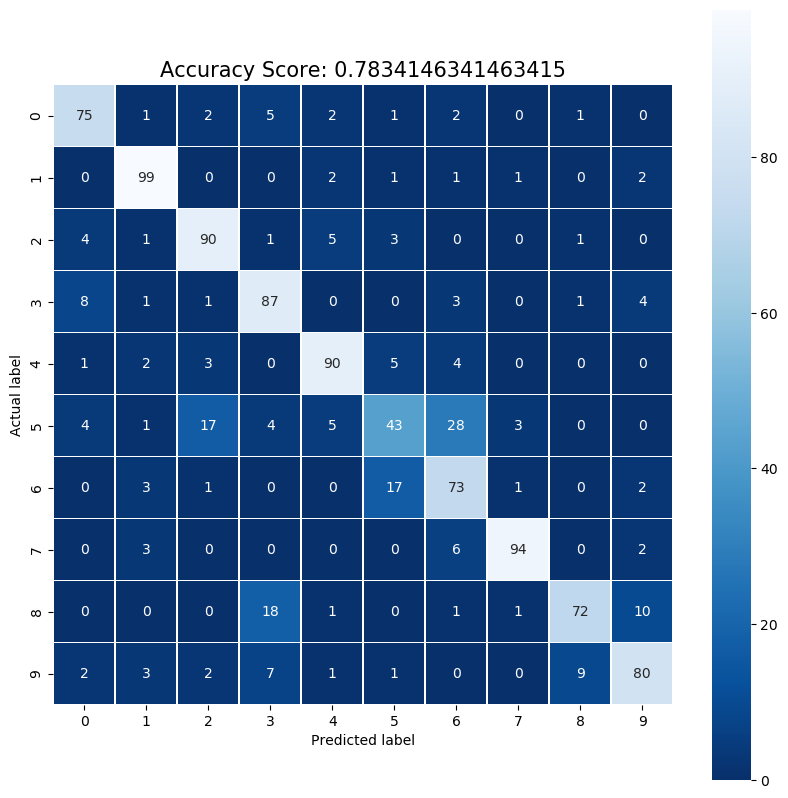

In [4]:
#load modelFood.h5 modelFood2.h5 modelFood3.h5
from sklearn.metrics import accuracy_score

modelFood2 = keras.models.load_model('modelFood2.h5')

print("Test Evaluation")
print(modelFood2.evaluate(test_x, test_y_one_hot))

#compute the classification report

print("Classification Report")
print(classification_report(test_y_one_hot.argmax(axis=1), modelFood2.predict(test_x).argmax(axis=1), target_names=class_names))

#compute the confusion matrix with seaborn
cm = confusion_matrix(test_y_one_hot.argmax(axis=1), modelFood2.predict(test_x).argmax(axis=1))
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_y_one_hot.argmax(axis=1), modelFood2.predict(test_x).argmax(axis=1)))

plt.title(all_sample_title, size = 15)
plt.show()







Test Evaluation
33/33 [==============================] - 1s 16ms/step - loss: 1.6311 - accuracy: 0.5356
[1.6311190128326416, 0.535609781742096]
Classification Report
33/33 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

       Apple       0.46      0.64      0.54        89
      Banana       0.40      0.37      0.38       106
     avocado       0.53      0.49      0.50       105
      cherry       0.53      0.63      0.58       105
        kiwi       0.48      0.61      0.54       105
       mango       0.44      0.35      0.39       105
      orange       0.71      0.79      0.75        97
  pinenapple       0.65      0.75      0.70       105
strawberries       0.59      0.49      0.53       103
  watermelon       0.59      0.28      0.38       105

    accuracy                           0.54      1025
   macro avg       0.54      0.54      0.53      1025
weighted avg       0.54      0.54      0.53      1025

33/33 [==============

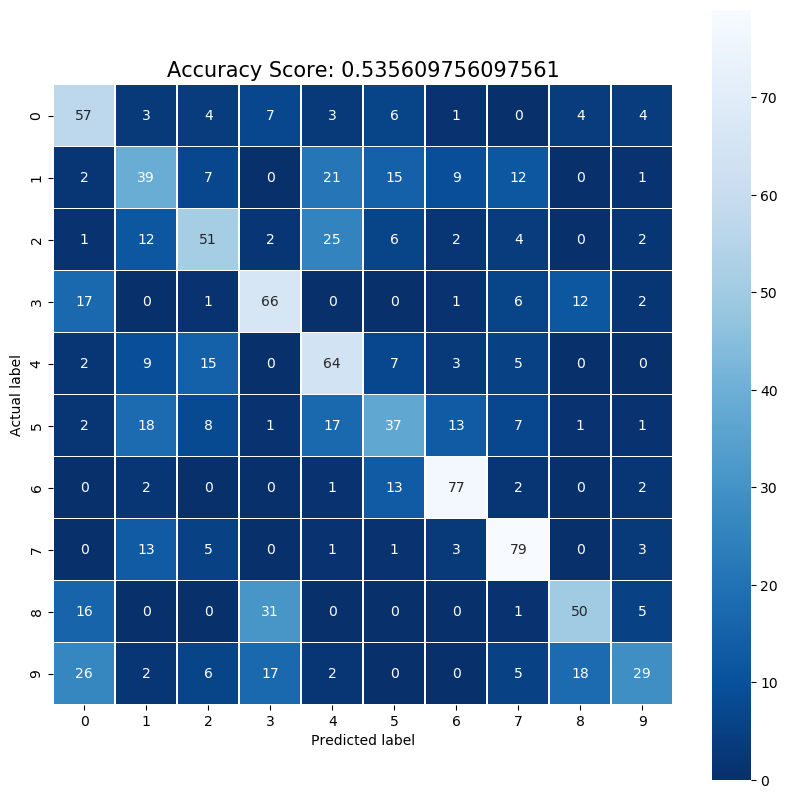

In [6]:
modelFood3 = keras.models.load_model('modelFood3.h5')

print("Test Evaluation")
print(modelFood3.evaluate(test_x, test_y_one_hot))

#compute the classification report

print("Classification Report")
print(classification_report(test_y_one_hot.argmax(axis=1), modelFood3.predict(test_x).argmax(axis=1), target_names=class_names))

#compute the confusion matrix with seaborn
cm = confusion_matrix(test_y_one_hot.argmax(axis=1), modelFood3.predict(test_x).argmax(axis=1))
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_y_one_hot.argmax(axis=1), modelFood3.predict(test_x).argmax(axis=1)))

plt.title(all_sample_title, size = 15)
plt.show()



Test Evaluation
33/33 [==============================] - 1s 14ms/step - loss: 1.4582 - accuracy: 0.5541
[1.4582329988479614, 0.5541463494300842]
Classification Report
33/33 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

       Apple       0.47      0.58      0.52        89
      Banana       0.52      0.42      0.46       106
     avocado       0.46      0.50      0.48       105
      cherry       0.65      0.65      0.65       105
        kiwi       0.53      0.55      0.54       105
       mango       0.37      0.24      0.29       105
      orange       0.68      0.85      0.76        97
  pinenapple       0.58      0.76      0.66       105
strawberries       0.59      0.55      0.57       103
  watermelon       0.62      0.48      0.54       105

    accuracy                           0.55      1025
   macro avg       0.55      0.56      0.55      1025
weighted avg       0.55      0.55      0.54      1025

33/33 [=============

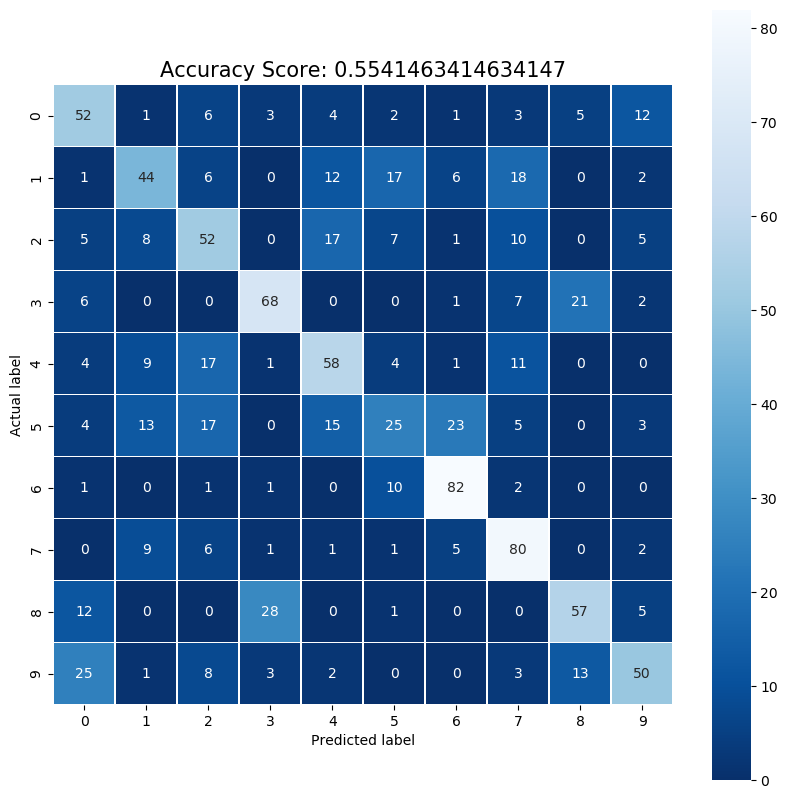

In [11]:
from sklearn.metrics import accuracy_score
model4 = keras.models.load_model('modelFood4WithWeightDecay1e-4.h5')

print("Test Evaluation")
print(model4.evaluate(test_x, test_y_one_hot))

#compute the classification report

print("Classification Report")
print(classification_report(test_y_one_hot.argmax(axis=1), model4.predict(test_x).argmax(axis=1), target_names=class_names))

#compute the confusion matrix with seaborn
cm = confusion_matrix(test_y_one_hot.argmax(axis=1), model4.predict(test_x).argmax(axis=1))
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_y_one_hot.argmax(axis=1), model4.predict(test_x).argmax(axis=1)))

plt.title(all_sample_title, size = 15)
plt.show()


Test Evaluation
33/33 [==============================] - 1s 14ms/step - loss: 2.4738 - accuracy: 0.3971
[2.4738118648529053, 0.3970731794834137]
Classification Report
33/33 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

       Apple       0.43      0.25      0.31        89
      Banana       0.24      0.07      0.10       106
     avocado       0.27      0.80      0.41       105
      cherry       0.45      0.67      0.54       105
        kiwi       0.40      0.33      0.36       105
       mango       0.22      0.12      0.16       105
      orange       0.65      0.72      0.68        97
  pinenapple       0.73      0.43      0.54       105
strawberries       0.37      0.54      0.44       103
  watermelon       0.38      0.05      0.08       105

    accuracy                           0.40      1025
   macro avg       0.41      0.40      0.36      1025
weighted avg       0.41      0.40      0.36      1025

33/33 [=============

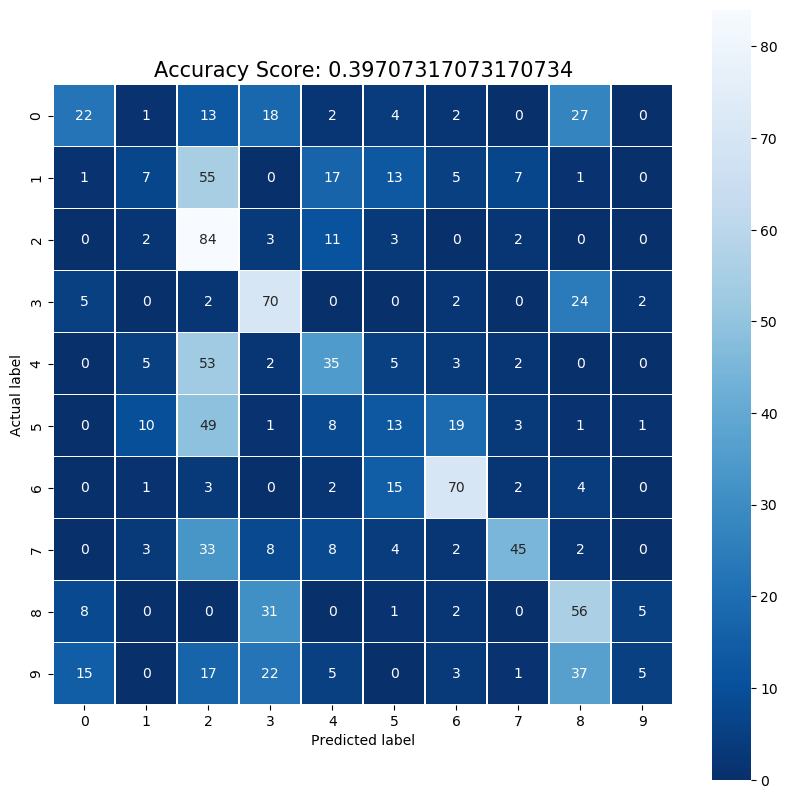

In [6]:
model42 = keras.models.load_model('modelFood42WithWeightDecay1e-2.h5')

print("Test Evaluation")
print(model42.evaluate(test_x, test_y_one_hot))

#compute the classification report

print("Classification Report")
print(classification_report(test_y_one_hot.argmax(axis=1), model42.predict(test_x).argmax(axis=1), target_names=class_names))

#compute the confusion matrix with seaborn
cm = confusion_matrix(test_y_one_hot.argmax(axis=1), model42.predict(test_x).argmax(axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')

plt.ylabel('Actual label')

plt.xlabel('Predicted label')

all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_y_one_hot.argmax(axis=1), model42.predict(test_x).argmax(axis=1)))

plt.title(all_sample_title, size = 15)

plt.show()
